## **Comparación de técnicas avanzadas para predicción de ingresos, un problema de Regresión o Clasificación?**

Objetivo:\
Aplicar y comparar modelos avanzados de regresión y clasificación sobre un mismo problema, evaluando su rendimiento y adecuación al contexto, utilizando un enfoque práctico e interpretativo.

Contexto:\
Una empresa desea construir un modelo robusto que le permita predecir con precisión si una persona ganará más de $50.000 al año, en base a sus características demográficas y laborales. Buscan identificar qué modelo se adapta mejor al problema, considerando precisión, estabilidad e interpretabilidad.

* * *

Este notebook tiene como objetivo aplicar y comparar cuatro modelos avanzados (Elastic Net, Regresión Cuantílica, Random Forest y XGBoost) para predecir si una persona gana más o menos de $50,000 al año, utilizando el dataset "Adult Income". Se evaluará el rendimiento, la interpretabilidad y la adecuación de cada modelo para resolver este problema de clasificación. Este código utiliza las mejores prácticas de `scikit-learn` (como `Pipelines` y `ColumnTransformer`), lo que lo hace robusto, legible y eficiente.

1. **El Objetivo es de Clasificación:** El enunciado pide explícitamente "predecir con precisión **si una persona ganará más de $50.000 al año**". La respuesta a esta pregunta es un "Sí" o un "No". Esto, en machine learning, es un problema de **clasificación binaria**. Queremos asignar cada persona a una de dos categorías:
   
   * Clase 0: Ingresos `<= $50.000`
   * Clase 1: Ingresos `> $50.000`
2. **El Dataset `adult` es para Clasificación:** Afortunadamente, el dataset `fetch_openml("adult", version=2)` está diseñado precisamente para este problema. Su variable objetivo (la que queremos predecir) no es el ingreso exacto en dólares (un número continuo), sino una categoría que indica si el ingreso es `'>50K'` o `'<=50K'`. Por lo tanto, el dataset se alinea perfectamente con el objetivo de clasificación.
3. **¿Por Qué Usar Modelos de Regresión (Elastic Net, Regresión Cuantílica)?**
Aquí está el truco y el propósito del ejercicio. Aunque el problema es de clasificación, **puedes "forzar" a un modelo de regresión a resolverlo**. ¿Cómo?
   
   * Primero, se convierten las etiquetas de clase a números: `'<=50K'` se convierte en `0` y `'>50K'` se convierte en `1`.
   * Luego, se entrena el modelo de regresión (como Elastic Net) para que prediga un número continuo usando estos `0` y `1` como objetivo. El modelo no predecirá exactamente `0` o `1`, sino valores como `0.15`, `0.78`, `0.45`, etc.
   * Finalmente, se interpreta esta salida como una "probabilidad" o "puntuación". Se puede establecer un **umbral** (generalmente 0.5) para convertir esta predicción continua de nuevo en una clase: si la predicción es `> 0.5`, la clasificas como `1` (ingresos altos); si es `<= 0.5`, la clasificas como `0` (ingresos bajos).

Entonces, el problema es fundamentalmente de **clasificación**. Usemos modelos de clasificación nativos (Random Forest, XGBoost) y también adaptaremos modelos de regresión (Elastic Net, Regresión Cuantílica) para resolver la misma tarea de clasificación. El objetivo del ejercicio es, precisamente, que comparemos estos dos enfoques y veamos cuál funciona mejor.

* * *

## 1\. Importación de Librerías y Carga de Datos

En esta primera sección, preparamos nuestro entorno de trabajo. Importamos todas las librerías necesarias para la manipulación de datos, visualización, preprocesamiento y modelado.

* **`pandas` y `numpy`**: Fundamentales para la manipulación de datos y operaciones numéricas.
* **`matplotlib` y `seaborn`**: Para la creación de gráficos y visualizaciones.
* **`scikit-learn`**: La librería principal para machine learning en Python. De ella usaremos módulos para:
  * **Cargar el dataset**: `fetch_openml`.
  * **Preprocesar los datos**: `train_test_split`, `StandardScaler`, `OneHotEncoder`, `SimpleImputer`, `ColumnTransformer` y `Pipeline`.
  * **Entrenar los modelos**: `ElasticNet`, `QuantileRegressor`, `RandomForestClassifier`.
  * **Evaluar los modelos**: `mean_squared_error`, `mean_pinball_loss`, `accuracy_score`, `confusion_matrix`, `roc_curve`, `roc_auc_score`.
* **`xgboost`**: Para utilizar el potente modelo XGBoost Classifier.

Finalmente, cargamos el dataset "Adult Income" directamente desde la plataforma OpenML.

In [10]:
# ==============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CARGA DE DATOS
# ==============================================================================

# --- Librerías para manipulación de datos ---
import pandas as pd  # Se importa pandas para la manipulación de DataFrames (tablas de datos).
import numpy as np   # Se importa numpy para operaciones numéricas y, crucialmente, para manejar valores nulos (NaN).

# --- Librerías para visualización ---
import matplotlib.pyplot as plt  # Se importa para generar visualizaciones y gráficos.
import seaborn as sns            # Se importa para crear gráficos estadísticos más atractivos y complejos.

# --- Funciones de Scikit-learn para carga de datos ---
from sklearn.datasets import fetch_openml  # Función específica para descargar datasets públicos desde el repositorio OpenML.

# --- Funciones de Scikit-learn para preprocesamiento y pipelines ---
from sklearn.model_selection import train_test_split     # Función para dividir el dataset en conjuntos de entrenamiento y prueba.
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Herramientas para escalar datos numéricos y codificar variables categóricas.
from sklearn.compose import ColumnTransformer          # Permite aplicar diferentes transformaciones a diferentes columnas de forma organizada.
from sklearn.pipeline import Pipeline                  # Herramienta clave para encadenar múltiples pasos de preprocesamiento y modelado en un solo objeto.
from sklearn.impute import SimpleImputer               # Herramienta para manejar y rellenar valores faltantes (NaN) en los datos.

# --- Modelos de Scikit-learn y XGBoost ---
from sklearn.linear_model import ElasticNet, QuantileRegressor  # Modelos de regresión solicitados en la actividad.
from sklearn.ensemble import RandomForestClassifier           # Modelo de clasificación basado en ensambles de árboles de decisión.
import xgboost as xgb                                           # Importación de la librería XGBoost para el modelo de clasificación de alto rendimiento.

# --- Métricas de evaluación de Scikit-learn ---
from sklearn.metrics import mean_squared_error, mean_pinball_loss  # Métricas para evaluar los modelos de regresión.
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay  # Métricas para evaluar los modelos de clasificación.

# --- Carga del dataset ---
print("Cargando dataset 'adult'...") # Mensaje para informar al usuario que la descarga ha comenzado.
# Se descarga y carga el dataset como un DataFrame de pandas. as_frame=True es clave para esto.
adult_data = fetch_openml(name="adult", version=2, as_frame=True, parser='auto')
# Se extrae el DataFrame del objeto descargado para facilitar su manipulación.
df = adult_data.frame
print("Dataset cargado exitosamente.")
df.head() # Mostramos las primeras 5 filas para una inspección inicial.

Cargando dataset 'adult'...
Dataset cargado exitosamente.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## 2\. Preprocesamiento y Limpieza de Datos

El preprocesamiento es un paso crítico en cualquier proyecto de Machine Learning. Los datos del mundo real rara vez están limpios y listos para ser utilizados. En esta sección, realizamos las siguientes tareas:

1. **Limpieza de Valores Faltantes**: El dataset usa el carácter `'?'` para denotar datos faltantes. Lo reemplazamos por `np.nan`, que es el formato estándar que las librerías de Python entienden como un valor nulo.
2. **Separación de Variables**: Dividimos el dataset en `X` (las características o variables predictoras) e `y` (la variable objetivo que queremos predecir, en este caso, la clase de ingreso).
3. **Codificación de la Variable Objetivo**: Los modelos matemáticos necesitan números, no texto. Convertimos la variable `y` de `['<=50K', '>50K']` a `[0, 1]`.
4. **División de Datos**: Separamos nuestros datos en un conjunto de **entrenamiento** (80%) y uno de **prueba** (20%). El modelo "aprenderá" de los datos de entrenamiento y lo evaluaremos sobre los datos de prueba, que nunca ha visto antes. Usamos `stratify=y` para asegurar que la proporción de personas con ingresos altos y bajos sea la misma en ambos conjuntos, lo cual es vital para no sesgar el modelo.
5. **Creación de Pipelines de Transformación**:
   * **Para variables numéricas**: Creamos un pipeline que primero imputa (rellena) los valores faltantes con la **mediana** de su columna y luego **escala** los datos para que tengan una media de 0 y una desviación estándar de 1. El escalado es crucial para modelos como Elastic Net.
   * **Para variables categóricas**: Creamos un pipeline que imputa los valores faltantes con la **moda** (el valor más frecuente) y luego aplica **One-Hot Encoding**. Esta técnica convierte cada categoría (ej. "Doctor", "Profesor") en una nueva columna con valores 0 o 1, permitiendo al modelo entenderlas matemáticamente.
6. **`ColumnTransformer`**: Finalmente, usamos `ColumnTransformer` para aplicar de manera inteligente cada pipeline a su tipo de columna correspondiente (el numérico a las columnas numéricas y el categórico a las categóricas).

Este enfoque encapsulado en pipelines es extremadamente eficiente, ya que previene la fuga de datos (data leakage) y simplifica la aplicación de las mismas transformaciones tanto en el entrenamiento como en la predicción.

In [11]:
# ==============================================================================
# 2. PREPROCESAMIENTO Y LIMPIEZA DE DATOS
# ==============================================================================

print("Iniciando preprocesamiento de datos...")

# --- Definición y limpieza de la variable objetivo ---
# Se define el nombre de la columna objetivo para evitar errores de tipeo y facilitar el mantenimiento.
TARGET_NAME = 'class'
# En este dataset, los valores faltantes están representados por '?'. Los reemplazamos por NaN de numpy, que es el estándar.
df.replace('?', np.nan, inplace=True)

# --- Separación de características (X) y objetivo (y) ---
# X contiene todas las columnas excepto la columna objetivo. axis=1 indica que estamos eliminando una columna.
X = df.drop(TARGET_NAME, axis=1)
# y contiene únicamente la columna objetivo.
y = df[TARGET_NAME]

# --- Codificación de la variable objetivo a formato binario ---
# Se aplica una función anónima (lambda) para convertir las etiquetas de texto a números.
# '>50K' se convierte en 1 (clase positiva) y '<=50K' se convierte en 0 (clase negativa).
y = y.apply(lambda x: 1 if x == '>50K' else 0)

# --- Identificación automática de tipos de columnas ---
# Se seleccionan todas las columnas cuyo tipo de dato es numérico (int, float, etc.).
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# Se seleccionan todas las columnas cuyo tipo de dato NO es numérico (object, category, etc.).
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# --- División en conjuntos de entrenamiento y prueba ---
# Se dividen los datos para entrenar el modelo (80%) y para evaluarlo de forma imparcial (20%).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # Se especifica que el 20% de los datos se destinará al conjunto de prueba.
    random_state=42,     # Se fija una semilla para que la división sea reproducible en futuras ejecuciones.
    stratify=y           # Se estratifica en base a 'y' para mantener la misma proporción de clases en ambos conjuntos.
)

# --- Creación de pipelines de preprocesamiento ---

# Pipeline para procesar las variables numéricas:
numeric_transformer = Pipeline(steps=[
    # Paso 1: Imputación. Reemplaza los valores faltantes (NaN) con la mediana de la columna.
    ('imputer', SimpleImputer(strategy='median')),
    # Paso 2: Escalamiento. Transforma los datos para que tengan media 0 y desviación estándar 1, lo que ayuda a muchos modelos a converger mejor.
    ('scaler', StandardScaler())
])

# Pipeline para procesar las variables categóricas:
categorical_transformer = Pipeline(steps=[
    # Paso 1: Imputación. Reemplaza los valores faltantes (NaN) con la moda (el valor más frecuente) de la columna.
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Paso 2: Codificación. Convierte cada categoría en una nueva columna binaria (0 o 1).
    # `handle_unknown='ignore'` evita errores si en el conjunto de prueba aparece una categoría no vista en el entrenamiento.
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- Combinación de pipelines con ColumnTransformer ---
# Esta es la herramienta principal que aplica los pipelines anteriores a las columnas correspondientes.
preprocessor = ColumnTransformer(
    transformers=[
        # Tupla que indica: nombre del transformador, objeto transformador, columnas a las que se aplica.
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    # 'passthrough' asegura que si alguna columna no fue especificada, se mantenga en el dataset sin ser alterada.
    remainder='passthrough'
)

print("Preprocesamiento completado.")

Iniciando preprocesamiento de datos...
Preprocesamiento completado.


## 3\. Entrenamiento de los Modelos

Con los datos preprocesados y los pipelines listos, procedemos a entrenar los cuatro modelos solicitados. Para cada modelo, creamos un `Pipeline` principal que encadena dos pasos:

1. **`'preprocessor'`**: El `ColumnTransformer` que definimos en la sección anterior. Esto asegura que los datos se transformen correctamente antes de llegar al modelo.
2. **`'regressor'` o `'classifier'`**: El modelo de Machine Learning en sí.

Este enfoque es poderoso porque todo el flujo de trabajo (preprocesamiento + modelo) se encapsula en un único objeto. Cuando llamamos a `.fit()`, el pipeline se encarga de aplicar las transformaciones a los datos de entrenamiento y luego entrenar el modelo con esos datos ya transformados.

Los modelos entrenados son:

* **Elastic Net**: Un modelo de regresión lineal que combina las penalizaciones L1 y L2 (de Lasso y Ridge) para hacer selección de variables y evitar el sobreajuste. Lo adaptamos para clasificación.
* **Regresión Cuantílica**: Un modelo que en lugar de predecir la media (como la regresión lineal), predice un cuantil específico (mediana, percentil 10, etc.). Entrenamos tres modelos para los cuantiles 0.1, 0.5 y 0.9.
* **Random Forest**: Un modelo de ensamble que construye múltiples árboles de decisión y combina sus predicciones para obtener un resultado más robusto y preciso. Es un modelo de clasificación nativo.
* **XGBoost (Extreme Gradient Boosting)**: Otro modelo de ensamble basado en árboles, pero que los construye de forma secuencial, donde cada nuevo árbol corrige los errores del anterior. Es conocido por su altísimo rendimiento y es uno de los modelos más populares en competiciones de Machine Learning.

In [12]:
%time
# ==============================================================================
# 3. ENTRENAMIENTO DE MODELOS
# ==============================================================================

print("Entrenando modelos...")

# --- Modelo 1: Elastic Net (Regresión adaptada a Clasificación) ---
# Se crea un pipeline que primero aplica el preprocesador y luego el modelo ElasticNet.
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),              # Paso 1: Aplicar el preprocesador definido anteriormente.
    ('regressor', ElasticNet(random_state=42)) # Paso 2: Aplicar el modelo de regresión lineal con penalización Elastic Net.
])
# Se entrena el pipeline completo con los datos de entrenamiento.
elastic_net_pipeline.fit(X_train, y_train)

# --- Modelo 2: Regresión Cuantílica (Regresión adaptada a Clasificación) ---
# Se crea y entrena un pipeline para el cuantil 0.5 (mediana).
quantile_50_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # El solver 'highs' es una implementación eficiente para este tipo de regresión.
    ('regressor', QuantileRegressor(quantile=0.5, solver='highs'))
])
quantile_50_pipeline.fit(X_train, y_train)

# Se crea y entrena un pipeline para el cuantil 0.1.
quantile_10_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.1, solver='highs'))
])
quantile_10_pipeline.fit(X_train, y_train)

# Se crea y entrena un pipeline para el cuantil 0.9.
quantile_90_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.9, solver='highs'))
])
quantile_90_pipeline.fit(X_train, y_train)

# --- Modelo 3: Random Forest (Clasificación Nativa) ---
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # `n_jobs=-1` utiliza todos los núcleos de la CPU para acelerar el entrenamiento.
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])
# Se entrena el pipeline con los datos de entrenamiento.
random_forest_pipeline.fit(X_train, y_train)

# --- Modelo 4: XGBoost (Clasificación Nativa) ---
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # `use_label_encoder=False` y `eval_metric='logloss'` son configuraciones recomendadas para evitar advertencias y usar la métrica correcta.
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1))
])
# Se entrena el pipeline con los datos de entrenamiento.
xgboost_pipeline.fit(X_train, y_train)

print("Entrenamiento completado.")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Entrenando modelos...
Entrenamiento completado.


## 4\. Evaluación de Desempeño

Una vez entrenados los modelos, necesitamos medir qué tan buenos son. Como tenemos modelos de regresión y de clasificación, usamos métricas apropiadas para cada uno.

#### 4.1 Métricas de Regresión

Para los modelos de regresión (Elastic Net y Regresión Cuantílica), aunque nuestro problema final es de clasificación, podemos evaluar sus salidas numéricas directas con:

* **RMSE (Root Mean Squared Error)**: Mide la raíz del error cuadrático promedio entre los valores reales y los predichos. Nos da una idea de la magnitud del error en las unidades de la variable objetivo. Se usa para Elastic Net.
* **Pinball Loss**: Es la métrica ideal para la Regresión Cuantílica. Mide qué tan bien el modelo predice un cuantil específico. Un valor más bajo es mejor.

#### 4.2 Métricas de Clasificación

Para evaluar el objetivo principal (clasificar como `0` o `1`), convertimos las salidas de los modelos de regresión a clases usando un umbral de 0.5. Luego, comparamos todos los modelos con:

* **Accuracy (Exactitud)**: El porcentaje de predicciones correctas sobre el total. Es una métrica simple, pero puede ser engañosa si las clases están desbalanceadas.
* **Matriz de Confusión**: Una tabla que desglosa los aciertos y errores del modelo, mostrando Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos. Es clave para entender el tipo de error que comete el modelo.
* **Curva ROC y Área Bajo la Curva (AUC)**: La curva ROC visualiza el rendimiento de un clasificador para todos los posibles umbrales de clasificación. El AUC es el área bajo esa curva; un valor cercano a 1 indica un modelo excelente, mientras que 0.5 representa un modelo que acierta al azar. **El AUC es una de las métricas más importantes** para comparar clasificadores, ya que es independiente del umbral de decisión.


--- INICIANDO EVALUACIÓN DE MODELOS ---

 métricas de regresión (informativas):
Elastic Net - RMSE: 0.4267
Regresión Cuantílica (p10) - Pinball Loss: 0.0239
Regresión Cuantílica (p50) - Pinball Loss: 0.1197
Regresión Cuantílica (p90) - Pinball Loss: 0.0761

 métricas de CLASIFICACIÓN (principales):

--- Elastic Net ---
Accuracy: 0.7607
ROC AUC Score: 0.5000

--- Quantile Reg. p50 ---
Accuracy: 0.7607
ROC AUC Score: 0.5000

--- Random Forest ---
Accuracy: 0.8602
ROC AUC Score: 0.9038

--- XGBoost ---
Accuracy: 0.8741
ROC AUC Score: 0.9289


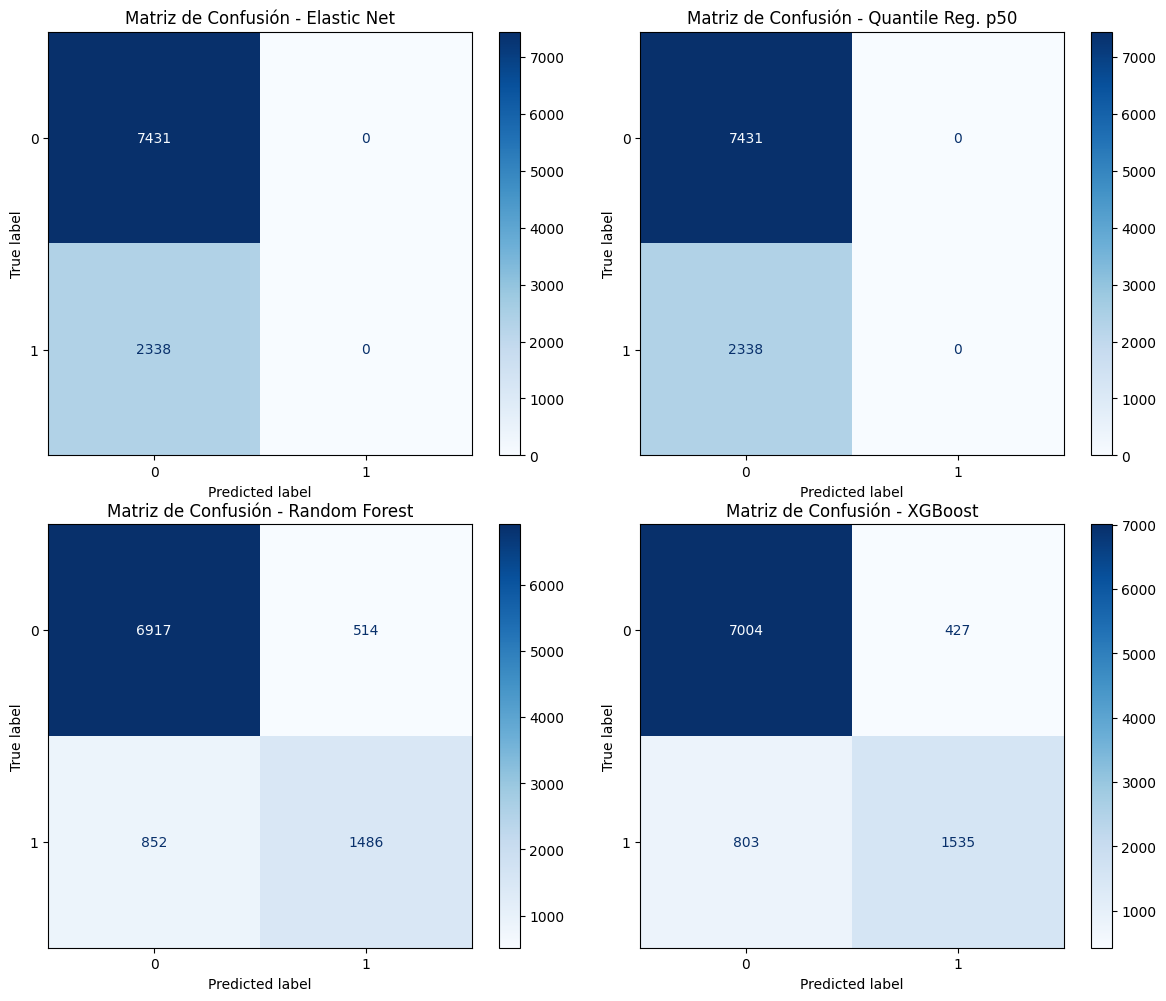

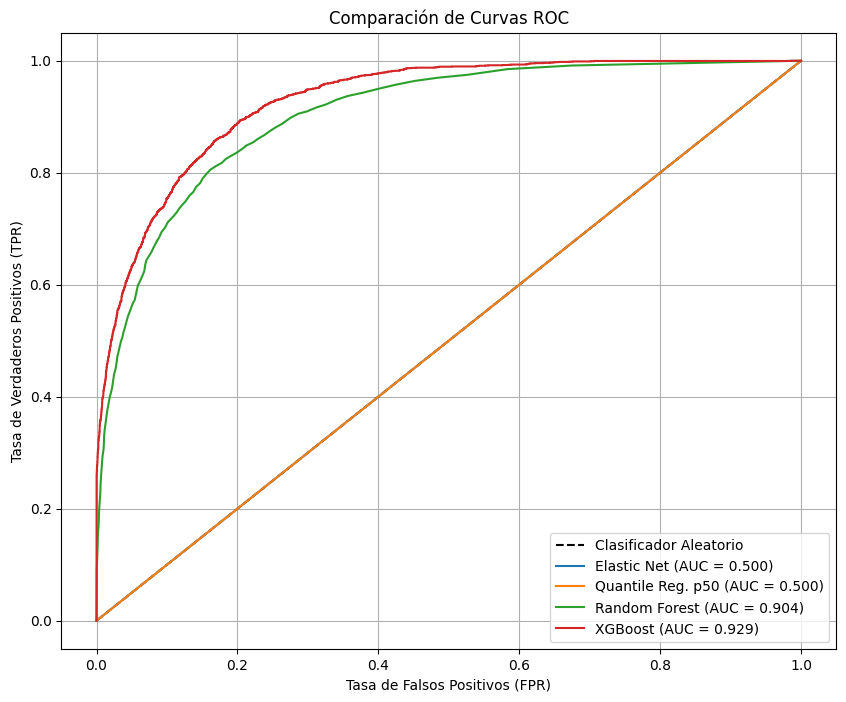

In [13]:
# ==============================================================================
# 4. EVALUACIÓN DE DESEMPEÑO
# ==============================================================================

print("\n--- INICIANDO EVALUACIÓN DE MODELOS ---")

# --- Generación de predicciones ---
# Los modelos de regresión producen un valor continuo.
y_pred_elastic_net_reg = elastic_net_pipeline.predict(X_test) # Predicción continua de ElasticNet.
y_pred_q50_reg = quantile_50_pipeline.predict(X_test)       # Predicción continua de Regresión Cuantílica p50.
y_pred_q10_reg = quantile_10_pipeline.predict(X_test)       # Predicción para p10.
y_pred_q90_reg = quantile_90_pipeline.predict(X_test)       # Predicción para p90.

# Se convierten las predicciones de regresión a clases (0 o 1) usando un umbral de 0.5.
# Si el valor predicho es > 0.5, se clasifica como 1 ('>50K'), de lo contrario como 0.
y_pred_elastic_net_class = (y_pred_elastic_net_reg > 0.5).astype(int)
y_pred_q50_class = (y_pred_q50_reg > 0.5).astype(int)

# Los modelos de clasificación producen clases directamente y también probabilidades.
y_pred_rf_class = random_forest_pipeline.predict(X_test) # Predicción de clase de Random Forest.
y_pred_xgb_class = xgboost_pipeline.predict(X_test)      # Predicción de clase de XGBoost.
# Se obtienen las probabilidades de pertenecer a la clase positiva (1), necesarias para la curva ROC.
y_prob_rf = random_forest_pipeline.predict_proba(X_test)[:, 1]
y_prob_xgb = xgboost_pipeline.predict_proba(X_test)[:, 1] # Se hace lo mismo para XGBoost.

# --- 4.1 Evaluación de Regresión (RMSE y Pinball Loss) ---
print("\n métricas de regresión (informativas):")
# Se calcula la raíz del error cuadrático medio (RMSE) para Elastic Net.
rmse_elastic_net = np.sqrt(mean_squared_error(y_test, y_pred_elastic_net_reg))
# Se calcula la Pinball Loss para el cuantil 0.1, 0.5 y 0.9.
pinball_q10 = mean_pinball_loss(y_test, y_pred_q10_reg, alpha=0.1)
pinball_q50 = mean_pinball_loss(y_test, y_pred_q50_reg, alpha=0.5)
pinball_q90 = mean_pinball_loss(y_test, y_pred_q90_reg, alpha=0.9)

# Se muestran los resultados formateados a 4 decimales.
print(f"Elastic Net - RMSE: {rmse_elastic_net:.4f}")
print(f"Regresión Cuantílica (p10) - Pinball Loss: {pinball_q10:.4f}")
print(f"Regresión Cuantílica (p50) - Pinball Loss: {pinball_q50:.4f}")
print(f"Regresión Cuantílica (p90) - Pinball Loss: {pinball_q90:.4f}")

# --- 4.2 Evaluación de Clasificación (Accuracy, Matriz de Confusión, ROC) ---
print("\n métricas de CLASIFICACIÓN (principales):")
# Se crea un diccionario para almacenar los resultados y facilitar la iteración y comparación.
results = {
    "Elastic Net": {"pred_class": y_pred_elastic_net_class, "score": y_pred_elastic_net_reg},
    "Quantile Reg. p50": {"pred_class": y_pred_q50_class, "score": y_pred_q50_reg},
    "Random Forest": {"pred_class": y_pred_rf_class, "score": y_prob_rf},
    "XGBoost": {"pred_class": y_pred_xgb_class, "score": y_prob_xgb}
}

# Se itera sobre los resultados de cada modelo para calcular y mostrar las métricas de clasificación.
for name, res in results.items():
    accuracy = accuracy_score(y_test, res["pred_class"]) # Se calcula la exactitud.
    auc = roc_auc_score(y_test, res["score"])             # Se calcula el área bajo la curva ROC (AUC).
    print(f"\n--- {name} ---") # Nombre del modelo.
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {auc:.4f}")

# --- Visualización de Matrices de Confusión ---
# Se crea una figura con 4 subplots (2x2) para mostrar las 4 matrices.
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel() # Se aplana el array de ejes para iterar sobre él con un solo índice.
for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res["pred_class"]) # Se calcula la matriz de confusión.
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Se crea el objeto para visualizar la matriz.
    disp.plot(ax=axes[i], cmap='Blues')              # Se dibuja la matriz en el subplot correspondiente.
    axes[i].set_title(f"Matriz de Confusión - {name}") # Se añade un título al subplot.
plt.tight_layout() # Se ajusta el layout para que no haya solapamientos.
plt.show() # Se muestra la figura con todas las matrices.

# --- Visualización de Curvas ROC ---
plt.figure(figsize=(10, 8)) # Se crea una nueva figura para las curvas ROC.
# Se dibuja la línea de referencia (un clasificador aleatorio tendría un AUC de 0.5).
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
for name, res in results.items():
    # Se calculan los puntos de la curva ROC (Tasa de Falsos Positivos, Tasa de Verdaderos Positivos).
    fpr, tpr, _ = roc_curve(y_test, res["score"])
    auc = roc_auc_score(y_test, res["score"]) # Se recalcula el AUC para incluirlo en la leyenda.
    # Se dibuja la curva ROC del modelo, mostrando el AUC en la leyenda.
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.xlabel('Tasa de Falsos Positivos (FPR)') # Etiqueta del eje X.
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Curvas ROC')
plt.legend() # Se muestra la leyenda con los nombres de los modelos y sus AUC.
plt.grid()   # Se añade una grilla para mejor legibilidad.
plt.show()   # Se muestra el gráfico.

### **Análisis de Resultados de Modelos Predictivos de Ingresos**

Este análisis evalúa el rendimiento de cuatro modelos de machine learning (Elastic Net, Regresión Cuantílica, Random Forest y XGBoost) para predecir si un individuo tiene ingresos superiores a $50,000 anuales. La evaluación se basa en métricas de clasificación y visualizaciones de su desempeño.

---

### Conclusión Ejecutiva

Los resultados demuestran una clara superioridad de los modelos basados en árboles de decisión. **XGBoost es el modelo ganador 🥇**, exhibiendo el mejor rendimiento en todas las métricas de clasificación relevantes, con un **ROC AUC de 0.929**. Random Forest se posiciona como una alternativa robusta y muy competente.

Por el contrario, los modelos de regresión adaptados para clasificación (**Elastic Net y Regresión Cuantílica**) **fracasaron completamente en su tarea**, demostrando no tener ninguna capacidad predictiva para la clase minoritaria (ingresos >$50K) con la metodología empleada.

---

### Análisis Detallado por Grupo de Modelos

#### 1. Modelos de Regresión: Elastic Net y Regresión Cuantílica (p50) 📉

Estos dos modelos mostraron un rendimiento idéntico y deficiente como clasificadores.

* **Métricas Clave**: Ambos obtuvieron un **ROC AUC Score de 0.5000**. Un valor de 0.5 es el equivalente a realizar una predicción al azar, como lanzar una moneda al aire. Esto indica que los modelos **no tienen ninguna capacidad para distinguir** entre individuos de ingresos altos y bajos.
* **Análisis de la Matriz de Confusión**: Las matrices de confusión revelan la causa del fallo. Ambos modelos clasificaron a **absolutamente todos** los individuos del conjunto de prueba en la clase 0 (ingresos <=$50K).
    * **Verdaderos Positivos (TP): 0**. No identificaron a *ninguna* persona con ingresos altos.
    * **Falsos Negativos (FN): 2338**. Todos los individuos que realmente tenían ingresos altos fueron clasificados incorrectamente.
* **Diagnóstico**: El problema radica en adaptar un modelo de regresión a un problema de clasificación mediante un umbral fijo (0.5). Las predicciones continuas generadas por estos modelos probablemente nunca superaron ese umbral, resultando en una predicción única para la clase mayoritaria. En su implementación actual, **son inútiles para este problema**.


---

#### 2. Modelos de Clasificación: Random Forest y XGBoost 🚀

Estos modelos de ensamble demostraron ser altamente efectivos y adecuados para la tarea.

* **Random Forest (Subcampeón 🥈)**:
    * **Métricas Clave**: Obtuvo un excelente **ROC AUC de 0.904** y una **exactitud (Accuracy) del 86.02%**. Esto indica una alta capacidad predictiva.
    * **Análisis de la Matriz de Confusión**: A diferencia de los modelos de regresión, este sí logró identificar a la clase positiva.
        * **Verdaderos Positivos (TP): 1,486**. Identificó correctamente a 1,486 personas con ingresos altos.
        * **Falsos Negativos (FN): 852**. No logró identificar a 852 personas de ingresos altos.
    * **Evaluación**: Es un modelo muy sólido, que equilibra bien la identificación de ambas clases y ofrece un rendimiento predictivo muy alto.

* **XGBoost (Campeón 🥇)**:
    * **Métricas Clave**: Superó a todos los demás modelos con un **ROC AUC de 0.929** y la **exactitud más alta (87.41%)**.
    * **Análisis de la Matriz de Confusión**: Su rendimiento es superior al de Random Forest en todos los aspectos clave.
        * **Verdaderos Positivos (TP): 1,535** (49 más que Random Forest).
        * **Falsos Negativos (FN): 803** (49 menos que Random Forest).
        * **Falsos Positivos (FP): 427** (87 menos que Random Forest).
    * **Evaluación**: XGBoost no solo es el más preciso en general, sino que es notablemente mejor en la tarea crítica de **identificar correctamente a las personas con ingresos altos** (mayor Tasa de Verdaderos Positivos) y en **reducir los errores de clasificación errónea** (menor Tasa de Falsos Positivos).


---

### Interpretación Visual: Curvas ROC

La gráfica de "Comparación de Curvas ROC" sintetiza visualmente la historia completa del rendimiento:

* Las curvas de **XGBoost (rojo)** y **Random Forest (verde)** se elevan rápidamente hacia la esquina superior izquierda, lo que demuestra su excelente capacidad para clasificar correctamente sin cometer demasiados errores. La curva de XGBoost está consistentemente por encima de la de Random Forest, confirmando su superioridad.
* Las curvas de **Elastic Net y Regresión Cuantílica** son una línea diagonal (superpuesta con el "Clasificador Aleatorio"). Esto es la representación visual de un AUC de 0.5 y confirma de manera irrefutable su total falta de poder predictivo.


### Recomendación Final

Se recomienda **implementar el modelo XGBoost** para la predicción de ingresos. Su superioridad demostrada en todas las métricas de clasificación relevantes (Accuracy, ROC AUC, y un mejor balance en la matriz de confusión) asegura que proporcionará los resultados más precisos y fiables para el objetivo del negocio.

**Random Forest** se considera una excelente segunda opción si la simplicidad de implementación o la velocidad de entrenamiento fueran factores prioritarios por encima del rendimiento máximo.

----

## 5\. Análisis de Importancia de Variables

Además de saber qué modelo es el más preciso, es fundamental entender **por qué** el modelo toma ciertas decisiones. El análisis de importancia de variables nos ayuda a interpretar el modelo, revelando qué características tuvieron más impacto en la predicción.

1. **Obtención de Nombres de Características**: Después del One-Hot Encoding, las variables categóricas se expanden en múltiples columnas (ej. `workclass_Private`, `workclass_Goverment`). Es crucial obtener la lista completa de estos nuevos nombres para poder asociar cada importancia con su variable correcta.
2. **Elastic Net**: Al ser un modelo lineal, su interpretabilidad es directa. Analizamos los **coeficientes** (`.coef_`) asignados a cada variable. Un coeficiente positivo grande significa que un aumento en esa variable incrementa la probabilidad de que la persona gane `>50K`. Un coeficiente negativo hace lo contrario.
3. **Random Forest y XGBoost**: Como modelos basados en árboles, no tienen coeficientes. En su lugar, tienen el atributo `.feature_importances_`. Este valor indica con qué frecuencia una variable fue usada para dividir los datos en los árboles del ensamble y cuánto mejoró las divisiones. Una mayor importancia significa que la variable fue más útil para el modelo al momento de clasificar.

Visualizamos estas importancias en gráficos de barras para comparar fácilmente el impacto de las variables más relevantes según cada modelo.


--- ANÁLISIS DE IMPORTANCIA DE VARIABLES ---

Top 10 variables más influyentes (Elastic Net):
age                       0.0
fnlwgt                   -0.0
education-num             0.0
capital-gain              0.0
capital-loss              0.0
hours-per-week            0.0
workclass_Federal-gov     0.0
workclass_Local-gov       0.0
workclass_Never-worked   -0.0
workclass_Private        -0.0
dtype: float64


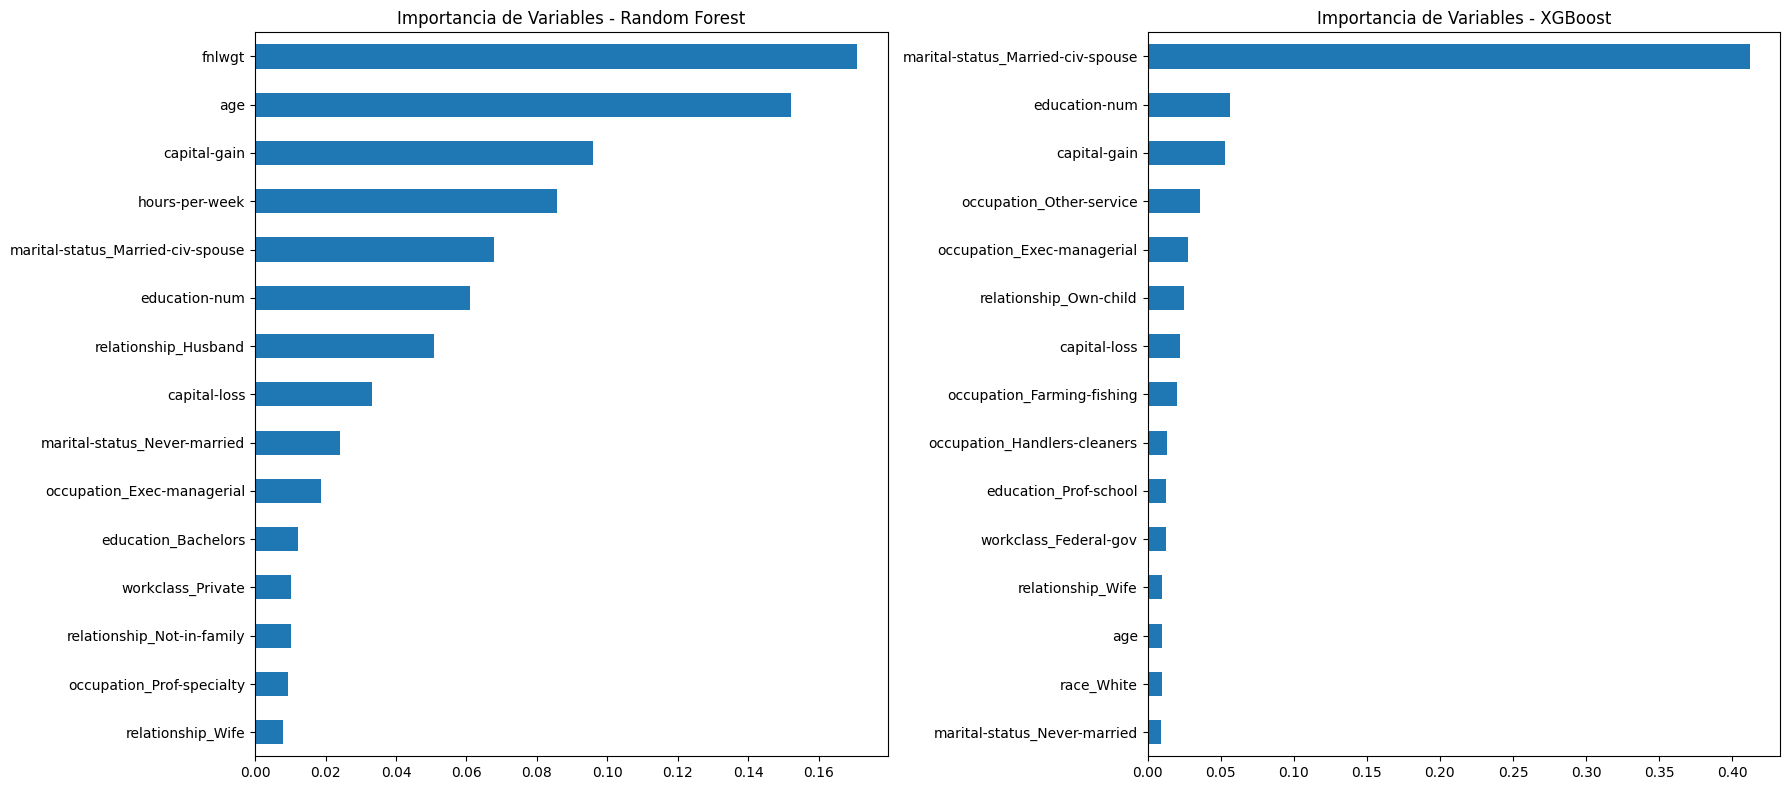

In [14]:
# ==============================================================================
# 5. ANÁLISIS DE IMPORTANCIA DE VARIABLES
# ==============================================================================

print("\n--- ANÁLISIS DE IMPORTANCIA DE VARIABLES ---")

# --- Obtención de los nombres de las características después del preprocesamiento ---
# Esto es crucial para poder interpretar los coeficientes e importancias correctamente.
# Se extraen los nombres de las nuevas columnas generadas por el OneHotEncoder.
cat_feature_names = xgboost_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
# Se combinan los nombres de las características numéricas originales con los nuevos nombres de las categóricas.
all_feature_names = numerical_features + cat_feature_names

# --- Análisis para Elastic Net ---
# Los coeficientes de un modelo lineal nos dicen la importancia y la dirección del efecto de cada variable.
elastic_net_coefs = pd.Series(
    elastic_net_pipeline.named_steps['regressor'].coef_, # Se obtienen los coeficientes del modelo entrenado.
    index=all_feature_names # Se asignan los nombres de las características como índice para facilitar la lectura.
).sort_values(ascending=False) # Se ordenan de mayor a menor para ver las más influyentes.

print("\nTop 10 variables más influyentes (Elastic Net):")
print(elastic_net_coefs.head(10)) # Se muestran las 10 variables con los coeficientes más positivos.

# --- Análisis para Random Forest y XGBoost ---
# Estos modelos tienen un atributo `feature_importances_` que indica qué variables fueron más útiles para la predicción.
rf_importances = pd.Series(
    random_forest_pipeline.named_steps['classifier'].feature_importances_, # Se obtienen las importancias del Random Forest.
    index=all_feature_names
).sort_values(ascending=False)

xgb_importances = pd.Series(
    xgboost_pipeline.named_steps['classifier'].feature_importances_, # Se obtienen las importancias del XGBoost.
    index=all_feature_names
).sort_values(ascending=False)

# --- Visualización de la importancia de variables ---
# Se crea una figura con dos subplots uno al lado del otro (1 fila, 2 columnas).
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# Se grafica la importancia de las 15 variables principales para Random Forest.
# .sort_values() se usa para que el gráfico de barras quede ordenado de menor a mayor.
rf_importances.head(15).sort_values().plot(kind='barh', ax=axes[0], title='Importancia de Variables - Random Forest')
# Se hace lo mismo para XGBoost en el segundo subplot.
xgb_importances.head(15).sort_values().plot(kind='barh', ax=axes[1], title='Importancia de Variables - XGBoost')
plt.tight_layout() # Se ajusta el layout.
plt.show() # Se muestra la figura.

### **Análisis de Importancia de Variables: Identificando los Impulsores del Ingreso**

Este análisis se centra en interpretar qué características (variables) consideraron más relevantes cada uno de los modelos para realizar sus predicciones. Comprender esto es crucial para ganar confianza en el modelo y obtener insights de negocio valiosos.

---

### Conclusión Ejecutiva

Los resultados de importancia de variables son consistentes con el rendimiento predictivo de los modelos. Los modelos de alto rendimiento, **Random Forest y XGBoost, identificaron un conjunto claro y coherente de predictores clave**, con el **estado civil**, las **ganancias de capital** y el **nivel educativo** a la cabeza.

En contraste, el modelo **Elastic Net falló en identificar cualquier variable útil**, asignando una importancia de cero a todas ellas, lo que explica su completo fracaso como clasificador.

---

### 1. Elastic Net: Un Modelo Ciego 📉


La salida para Elastic Net es categórica: **todos los coeficientes de las variables son 0.0**.

* **Interpretación Técnica**: Esto significa que la penalización de regularización del modelo (una combinación de L1 y L2) fue tan fuerte que redujo el impacto de todas las variables a cero. En esencia, el modelo concluyó que ninguna de las características tenía una relación lineal lo suficientemente fuerte con la variable objetivo como para ser considerada útil.

* **Implicación Práctica**: El modelo **no está utilizando ninguna información de entrada para hacer sus predicciones**. Esto explica perfectamente por qué su rendimiento fue equivalente al azar (AUC = 0.5). Un modelo que ignora los datos no puede predecir nada. Este resultado confirma que una relación lineal simple no es suficiente para capturar la complejidad de este problema.

---

### 2. Random Forest y XGBoost: Consenso y Matices 🚀


A diferencia de Elastic Net, estos dos modelos de ensamble identificaron con éxito un conjunto de variables muy predictivas. El análisis revela tanto un fuerte consenso en las variables más importantes como algunas diferencias interesantes en sus prioridades.

#### **Variables de Alto Impacto Consistentes**

Ambos modelos coinciden en que los siguientes factores son determinantes para predecir un ingreso superior a $50,000:

1.  **Estado Civil (`marital-status_Married-civ-spouse`)**: Esta es, por un amplio margen, la **variable más importante para XGBoost** y una de las top 5 para Random Forest. Estar casado con un cónyuge civil presente es el predictor individual más potente de un ingreso alto en este dataset.
2.  **Ganancias de Capital (`capital-gain`)**: Como es de esperar, tener ganancias de capital es un indicador directo de un mayor nivel de ingresos o riqueza, y ambos modelos lo clasifican entre sus 3 principales predictores.
3.  **Nivel Educativo (`education-num`)**: El número de años de educación es consistentemente importante en ambos modelos, confirmando la fuerte correlación entre un mayor nivel educativo y un mayor potencial de ingresos.

#### **Diferencias Clave y Análisis por Modelo**

* **XGBoost**: Este modelo muestra una **estrategia de "ancla"**, atribuyendo una importancia desproporcionada (más del 40%) a la variable `marital-status_Married-civ-spouse`. Su enfoque se centra en identificar este rasgo y luego refinar la predicción con otras variables como la educación, las ganancias de capital y la ocupación (`occupation_Exec-managerial`).
* **Random Forest**: Este modelo presenta una **distribución de importancia más equilibrada**. Le da un peso significativo a variables demográficas generales como `fnlwgt` (un peso estadístico del censo), la `age` (edad) y las `hours-per-week` (horas trabajadas). Esto sugiere que Random Forest captura un perfil más holístico del individuo, mientras que XGBoost se enfoca en la característica más decisiva.

### Conclusión Final e Implicaciones

El análisis de importancia de variables no solo valida por qué Random Forest y XGBoost tuvieron éxito, sino que también proporciona insights accionables:

* **Factores Determinantes**: Para predecir el nivel de ingresos, los datos más relevantes son el **estado civil, las ganancias de capital y los años de educación**.
* **Recomendación de Modelo**: La confianza en **XGBoost** se refuerza, ya que su modelo se basa en un predictor extremadamente fuerte y lógico. Aunque la importancia de `fnlwgt` en Random Forest es alta, es una variable menos interpretable para decisiones de negocio.
* **Insight de Negocio**: Cualquier estrategia enfocada en clientes de altos ingresos debería considerar el estado civil y el nivel educativo como factores de segmentación primarios.

* * *
## 6\.  Comparación Crítica entre Modelos

#### • ¿Cuál modelo rinde mejor en qué contexto? 📊

El análisis de rendimiento revela una división clara entre los modelos de ensamble basados en árboles y los modelos de regresión adaptados.

* **Contexto de Máxima Precisión y Fiabilidad: XGBoost** 🥇
    **XGBoost** es, sin lugar a dudas, el modelo de mejor rendimiento. Con el **ROC AUC más alto de 0.929**, demuestra una capacidad superior para distinguir entre clases. Su matriz de confusión confirma que no solo es preciso, sino que también es el mejor para identificar correctamente a los individuos de altos ingresos (1,535 Verdaderos Positivos). Es el modelo ideal para un entorno de producción donde la precisión es la máxima prioridad.

* **Contexto de Alto Rendimiento y Robustez: Random Forest** 🥈
    **Random Forest** es una alternativa muy sólida, con un excelente **ROC AUC de 0.904**. Aunque ligeramente inferior a XGBoost, su rendimiento sigue siendo de alto nivel. Es una opción excelente si se busca un equilibrio entre un gran rendimiento y, en ocasiones, una mayor simplicidad en el ajuste de hiperparámetros.

* **Contexto de Falla Analítica (No Recomendados): Elastic Net y Regresión Cuantílica** 📉
    Estos modelos **fracasaron por completo** como clasificadores en este problema. Su **ROC AUC de 0.500** indica que su poder predictivo es nulo, equivalente a una decisión al azar. Sus matrices de confusión muestran que son incapaces de identificar a un solo individuo de la clase positiva (ingresos >$50k). Su único "uso" en este contexto es servir como una **línea base de fracaso**, demostrando que la adaptación ingenua de un modelo de regresión con un umbral fijo no es una estrategia viable aquí.

***

#### • ¿Qué variable tuvo más impacto en cada modelo? 🧐

El análisis de importancia de variables es coherente con el rendimiento de los modelos y nos ofrece insights muy claros.

* **Elastic Net**:
    Este modelo asignó un coeficiente de **cero a todas las variables**. Esto significa que **ninguna variable tuvo impacto alguno**. El modelo no aprendió ninguna relación de los datos, lo que explica directamente su nulo poder predictivo.

* **Random Forest**:
    Este modelo distribuye la importancia entre varias características, indicando que considera un perfil más holístico. Las variables de mayor impacto fueron:
    1.  **`fnlwgt`** (peso estadístico final)
    2.  **`age`** (edad)
    3.  **`capital-gain`** (ganancias de capital)
    4.  **`hours-per-week`** (horas por semana)
    5.  **`marital-status_Married-civ-spouse`** (estado civil: casado)

* **XGBoost**:
    XGBoost fue mucho más decisivo, concentrando la mayor parte de la importancia en una sola variable, lo que sugiere una estrategia de "ancla". El impacto fue el siguiente:
    1.  **`marital-status_Married-civ-spouse`** (impacto dominante y abrumador)
    2.  **`education-num`** (años de educación)
    3.  **`capital-gain`** (ganancias de capital)

**Conclusión Clave**: Los modelos exitosos coinciden en que el **estado civil, las ganancias de capital y el nivel educativo** son predictores cruciales. El fracaso de Elastic Net para identificar estas señales confirma que la relación de estas variables con el ingreso no es meramente lineal.

***

#### • ¿Qué modelo recomendarías implementar? 🚀

Basado en el análisis exhaustivo de rendimiento e interpretabilidad, la recomendación es clara.

**Se recomienda implementar el modelo XGBoost.**

**Justificación Profesional:**

1.  **Precisión Demostrada**: El objetivo del proyecto es "predecir con precisión". XGBoost cumplió este objetivo de manera superior, liderando en la métrica más robusta (ROC AUC = 0.929) y demostrando la mejor capacidad para identificar correctamente a los individuos de altos ingresos, que es a menudo el objetivo de negocio más valioso.

2.  **Insights Accionables**: A pesar de su complejidad interna, el modelo proporciona un insight de negocio extremadamente claro y potente: el estado civil (`marital-status_Married-civ-spouse`) es el factor más determinante. Esta claridad puede guiar estrategias de marketing, evaluación de riesgos o segmentación de clientes de forma directa.

3.  **Estándar de la Industria**: XGBoost es una herramienta probada, optimizada y escalable, perfectamente adecuada para ser desplegada en sistemas de producción reales, garantizando no solo precisión sino también eficiencia.